# Business Problem

A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts. 

 

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. The company wants to know:

    - Which variables are significant in predicting the price of a car
    - How well those variables describe the price of a car
    
Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the Americal market. 

## Step 0 : Imports & Utility Functions

In [48]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(42)
from sklearn.preprocessing import MinMaxScaler

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# statmodel linear regression
import statsmodels.api as sm
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Plot distribution in data-diversity with categorical features
def plot_distribution(data, feature_list):
    plt.figure(figsize=(16, 24))
    
    for idx,feature in enumerate(feature_list):
        plt.subplot(6,2,idx+1)
        values = (data[feature].value_counts(normalize=True)*100)
        ax = values.plot.bar(color=sns.color_palette('deep', 16))
        ax.set_ylabel('% in Data', fontsize=16)
        ax.set_xlabel(feature, fontsize=8)

## Step 1 : Data 
### Reading | Understanding | Cleaning

In [4]:
#Read the dataset
cars = pd.read_csv('./data/CarPrice_Assignment.csv')
print("Data Size  : {}".format(cars.shape))

# Check the head of the dataset
cars.head()                   

Data Size  : (205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
# Check for Datatypes 
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

#### Missing Data
From the above we can see that there are no null data in ur dataset, hence we would not require any data imputation techniques.
Let's further verify this.

In [6]:
# percentage of missing values in each column
round(cars.isnull().sum()/len(cars.index), 2)*100

car_ID              0.0
symboling           0.0
CarName             0.0
fueltype            0.0
aspiration          0.0
doornumber          0.0
carbody             0.0
drivewheel          0.0
enginelocation      0.0
wheelbase           0.0
carlength           0.0
carwidth            0.0
carheight           0.0
curbweight          0.0
enginetype          0.0
cylindernumber      0.0
enginesize          0.0
fuelsystem          0.0
boreratio           0.0
stroke              0.0
compressionratio    0.0
horsepower          0.0
peakrpm             0.0
citympg             0.0
highwaympg          0.0
price               0.0
dtype: float64

In [7]:
# Check distribution
cars.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


#### Data Cleaning
As mentioned in the problem statement, we separate the company_name from the model name.
Also we check for duplicates and drop the unique identifier for **car_id**

In [8]:
# Removing car_ID as it's an unique identifier and not a feature
cars.drop('car_ID',axis=1,inplace=True)

print("Data before removing duplicates : {}".format(cars.shape[0]))
# Let's drop(if any) duplicate data points 
cars = cars.drop_duplicates()
print("Data before after duplicates : {}".format(cars.shape[0]))

# Separating Car Brand from Car Type
cars['car_company'] = cars['CarName'].apply(lambda x: x.split( )[0])
cars.drop('CarName',axis=1,inplace=True)
print("Unique Car Brands : {} ".format(cars['car_company'].unique()))
      
# Correcting the Spells in Car Brand.
cars['car_company'].replace('maxda','mazda',inplace=True)
cars['car_company'].replace('Nissan','nissan',inplace=True)
cars['car_company'].replace('porcshce','porsche',inplace=True)
cars['car_company'].replace('toyouta','toyota',inplace=True)
cars['car_company'].replace(['vokswagen','vw'],'volkswagen',inplace=True)
      
cars.head()

Data before removing duplicates : 205
Data before after duplicates : 205
Unique Car Brands : ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo'] 


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,car_company
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


## Step 2: Visualising the Data

We will divide the dataset columnsto **Categorical** & **Numerical** Features. 
We will try to do the following :

- Univariate Analyse & Distribution of Categorical Variables.
- Bi-variate Analysis, Co-relation , Multicollinearity will be checked for.
- See if some predictors directly have a strong association with the outcome variable


In [9]:
cat_cols = ['symboling', 'car_company', 'fueltype', 'aspiration', 'doornumber','carbody', 'drivewheel', 'enginelocation',
            'enginetype', 'cylindernumber','fuelsystem']

num_cols = ['wheelbase', 'carlength','carwidth', 'carheight', 'curbweight','enginesize','boreratio','stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']

#### Visualising Categorical Variables

As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables over the **price** which is our dependent variable. This will also help us see outliers

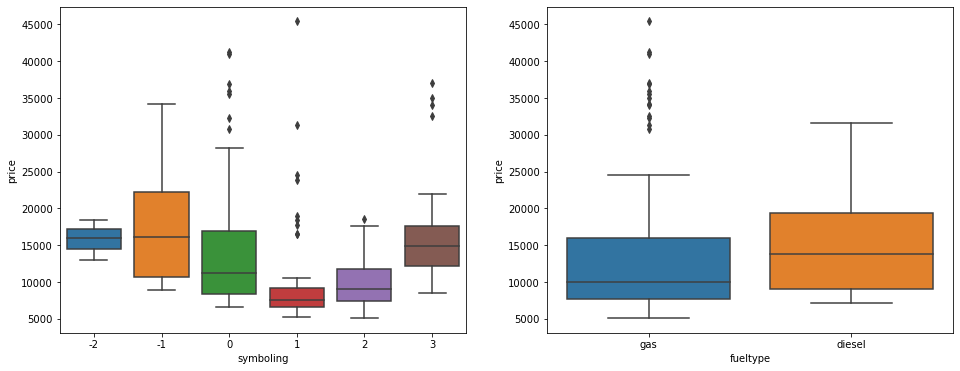

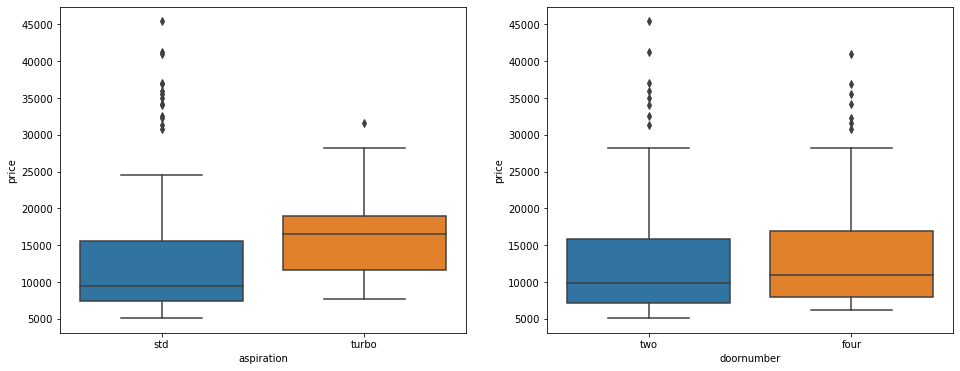

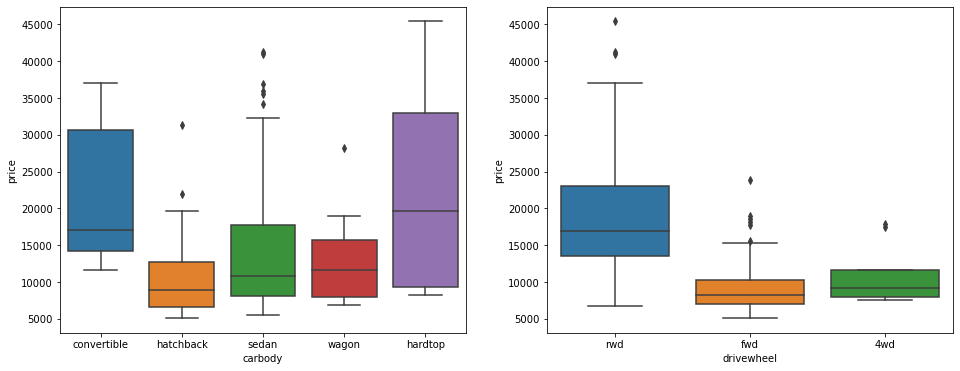

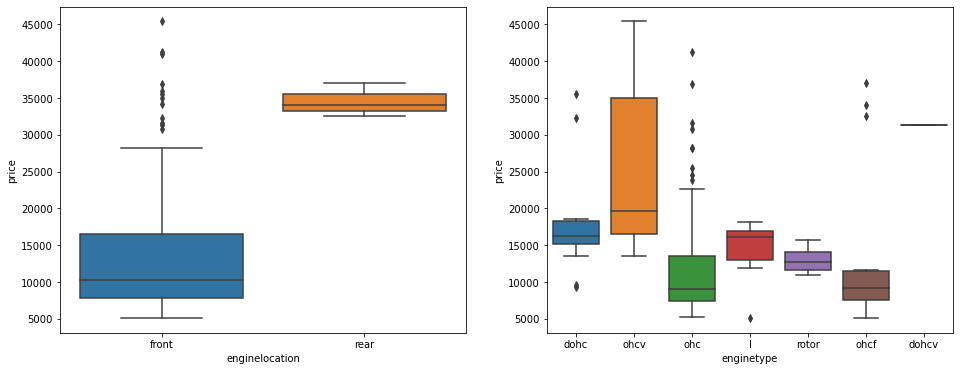

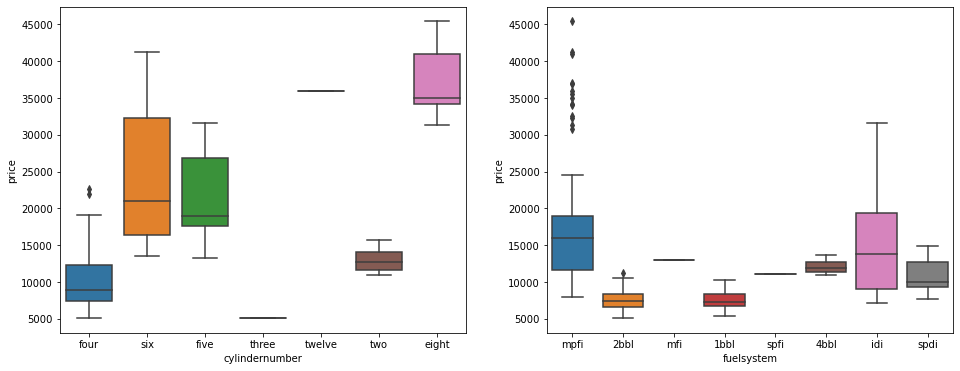

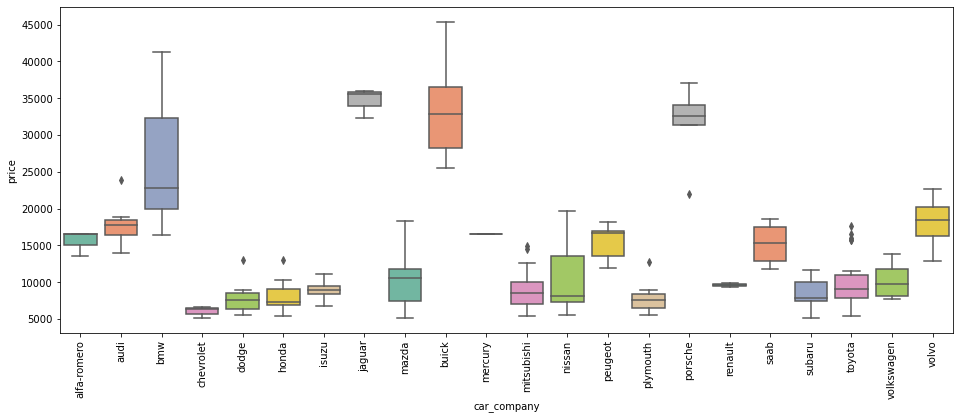

In [10]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxplot(x = 'symboling', y = 'price', data = cars)
plt.subplot(1,2,2)
sns.boxplot(x = 'fueltype', y = 'price', data = cars)
plt.show()

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxplot(x = 'aspiration', y = 'price', data = cars)
plt.subplot(1,2,2)
sns.boxplot(x = 'doornumber', y = 'price', data = cars)
plt.show()

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxplot(x = 'carbody', y = 'price', data = cars)
plt.subplot(1,2,2)
sns.boxplot(x = 'drivewheel', y = 'price', data = cars)
plt.show()

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxplot(x = 'enginelocation', y = 'price', data = cars)
plt.subplot(1,2,2)
sns.boxplot(x = 'enginetype', y = 'price', data = cars)
plt.show()

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.boxplot(x = 'cylindernumber', y = 'price', data = cars)
plt.subplot(1,2,2)
sns.boxplot(x = 'fuelsystem', y = 'price', data = cars)
plt.show()

# plt.figure(figsize=(16, 6))

# plt.show()

plt.figure(figsize=(16, 6))
sns.boxplot(x = 'car_company', y = 'price', palette="Set2", data = cars)
plt.xticks(rotation=90)
plt.show()

**Observations**

1. **fueltype** seems to have difference in price. Diesel cars being more expensive in general. Though some gas type cars are very heavily priced(outliers).  
2. **aspiration** seems to have difference in price. Turbo cars being more expensive in general. Though some std type cars are very heavily priced (outliers). 
3. A clear distinction can be seen with **Rear Engine** & **Rear Drive Wheel**  cars being highly priced in their categories.
4. **Convertible** & **HardTop** Types car are more expensive than there counterparts
5. Prices based on car company is dispersed. We can categories it to low,mid,high,luxury type brands.
6. Some companies have a wide range of products and price like BMW, Buick, while some have very selective models/price range like Renault


#### Visualizing Distribution of Categorical Features

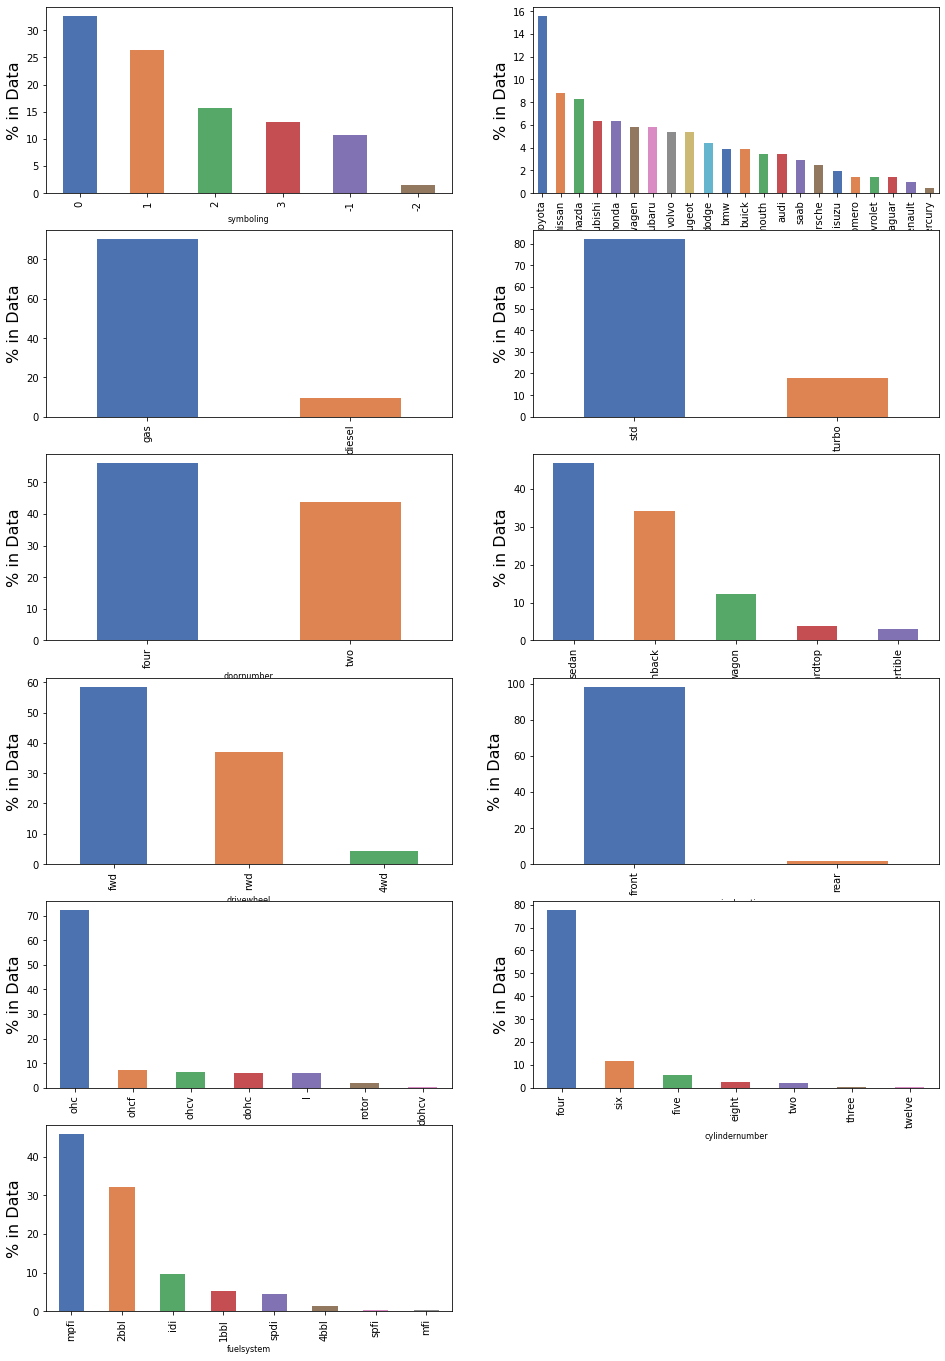

In [11]:
plot_distribution(cars,cat_cols)

**Observations**

1. Toyota has the largest market share as a car brand.
2. Based on the observation , the majority market share for the cars have the below features :
    - symboling : Rating 0
    - fueltype : gas
    - aspiration : std
    - doornumber : Four
    - carbody : sedan
    - drivewheel : fwd
    - enginelocation : front
    - enginetype : ohc
    - cylindernumber : four
    - fuelsystem : mpfi

#### Visualising Numeric Variables

We would now see the dependency between numerical features and how they are related to each other with a **pairplot**

In [12]:
print("Numerical Columns : {}".format(num_cols))

Numerical Columns : ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


<Figure size 1440x720 with 0 Axes>

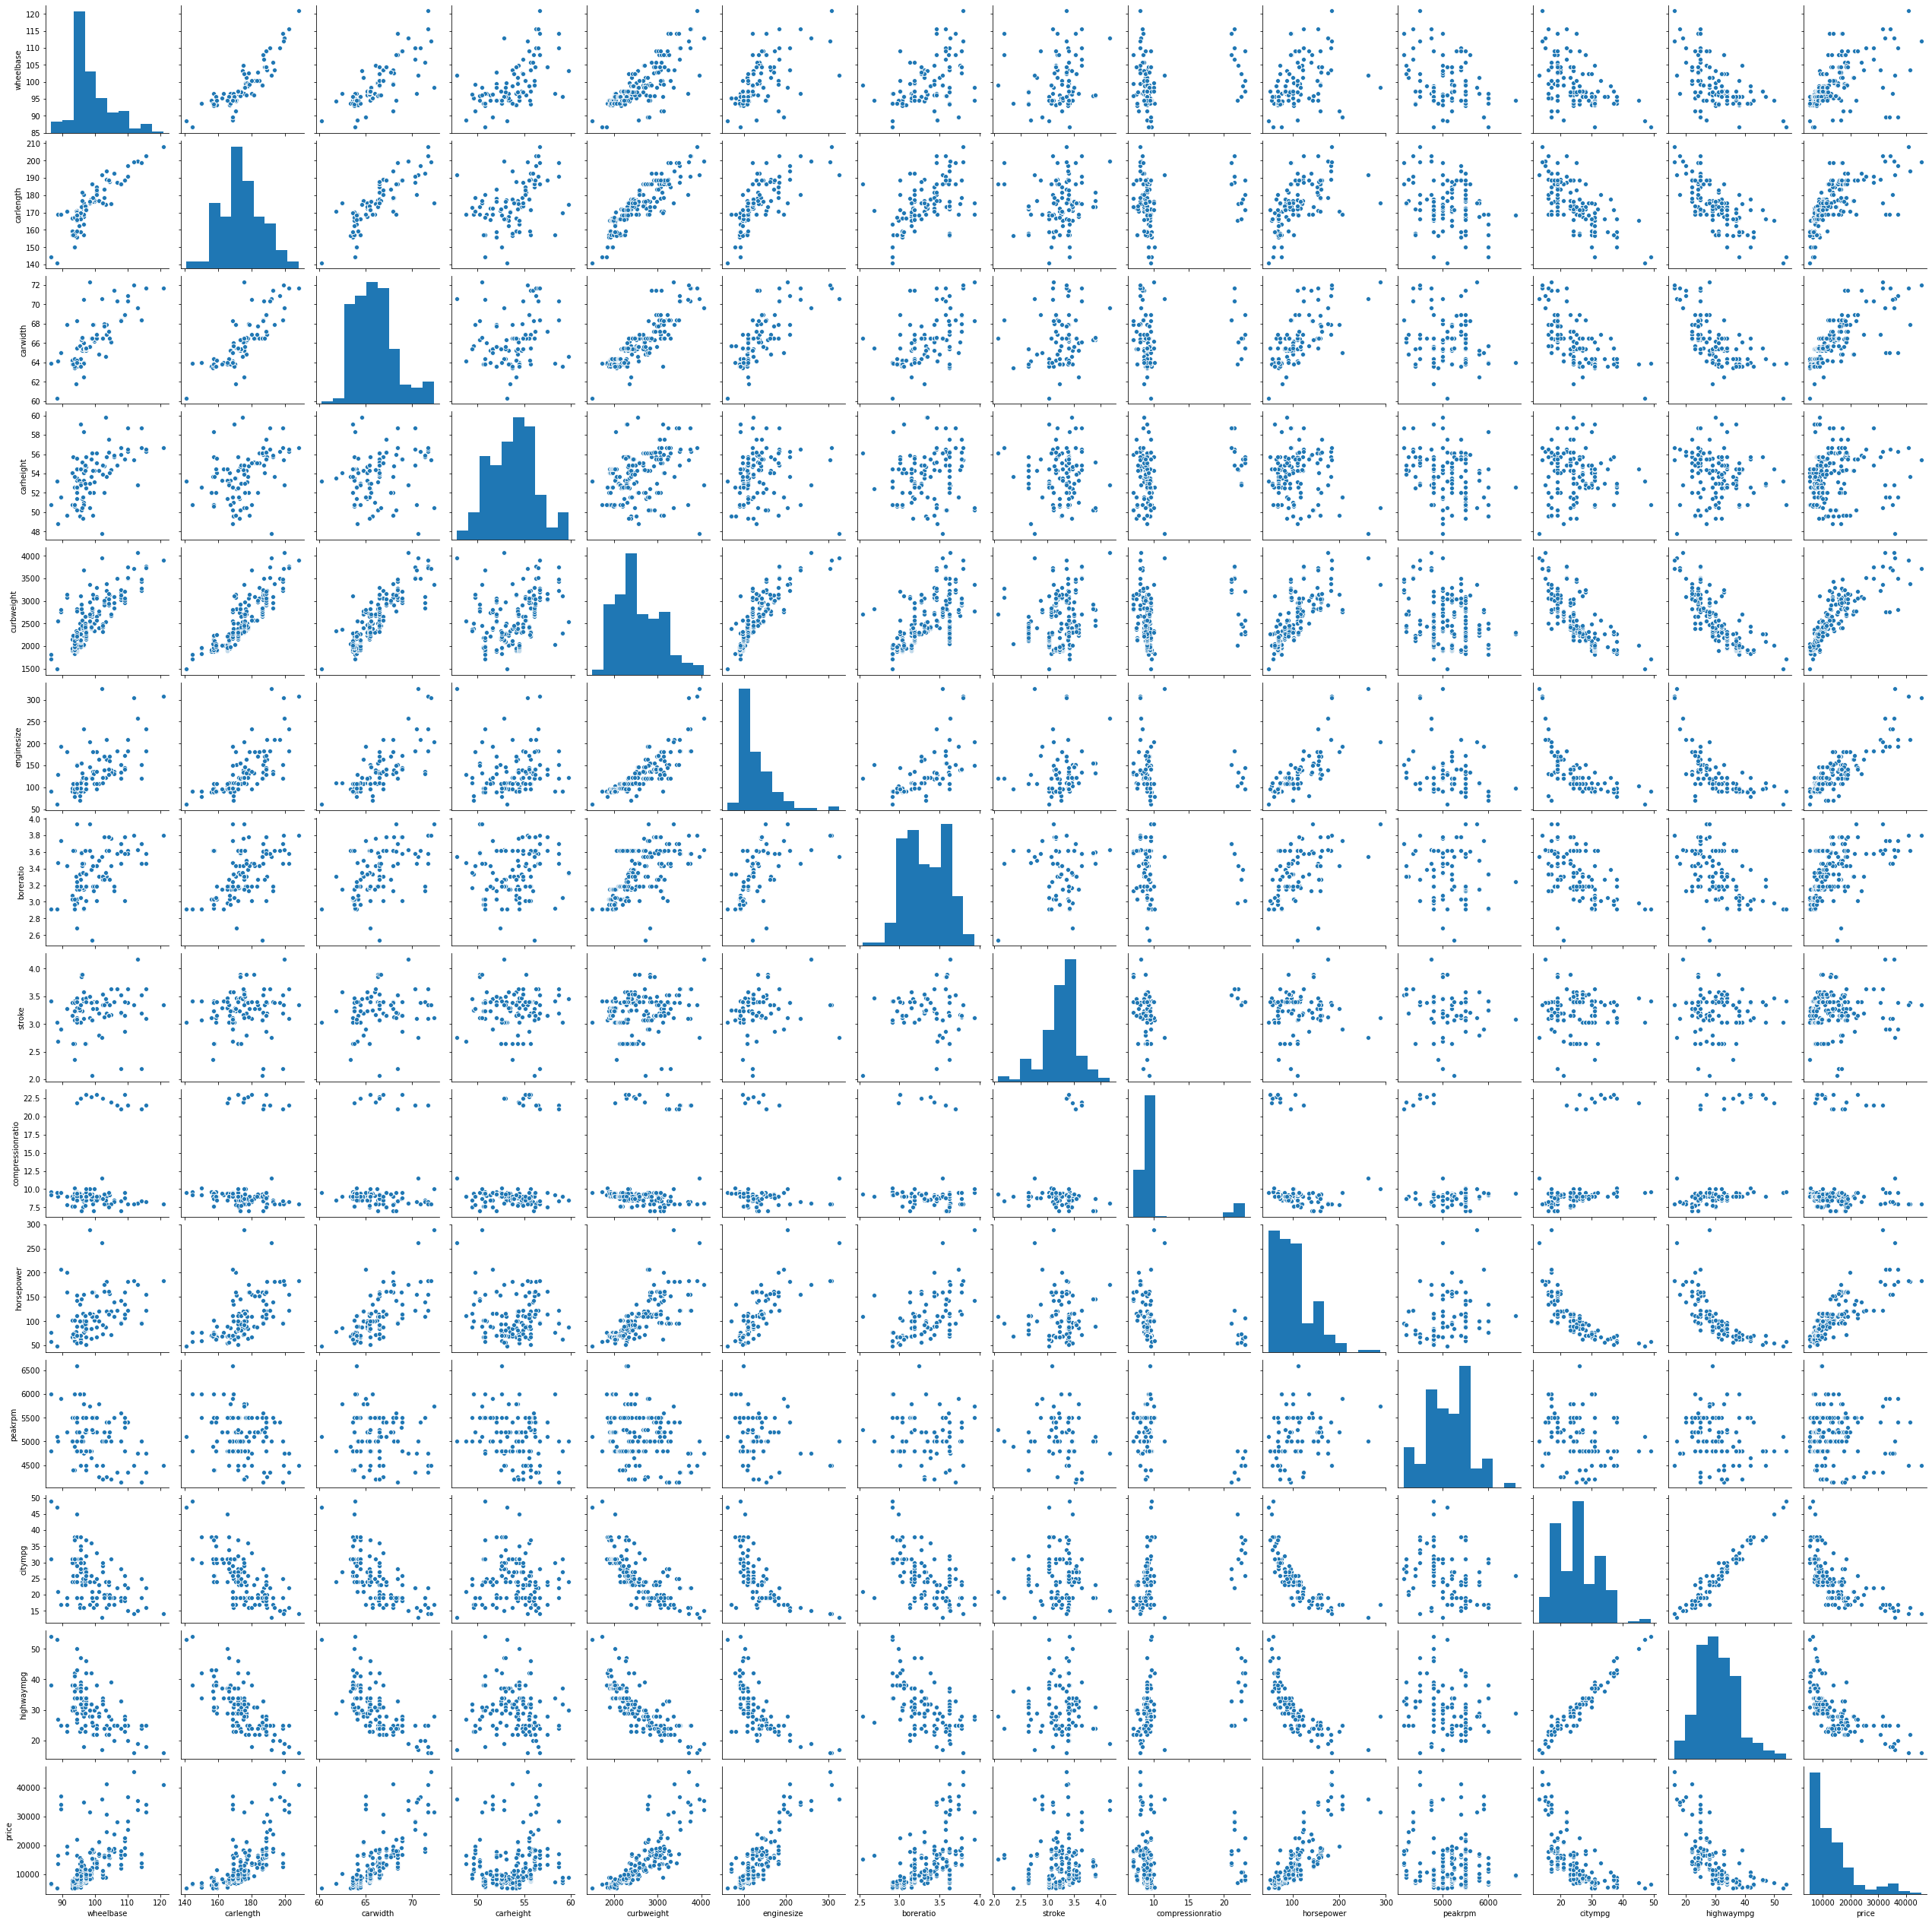

In [13]:
plt.figure(figsize = (20, 10))
grid = sns.pairplot(cars[num_cols])
plt.show()

#### Visualizing Correlation

We would now see the correlation factor between various numberical features.

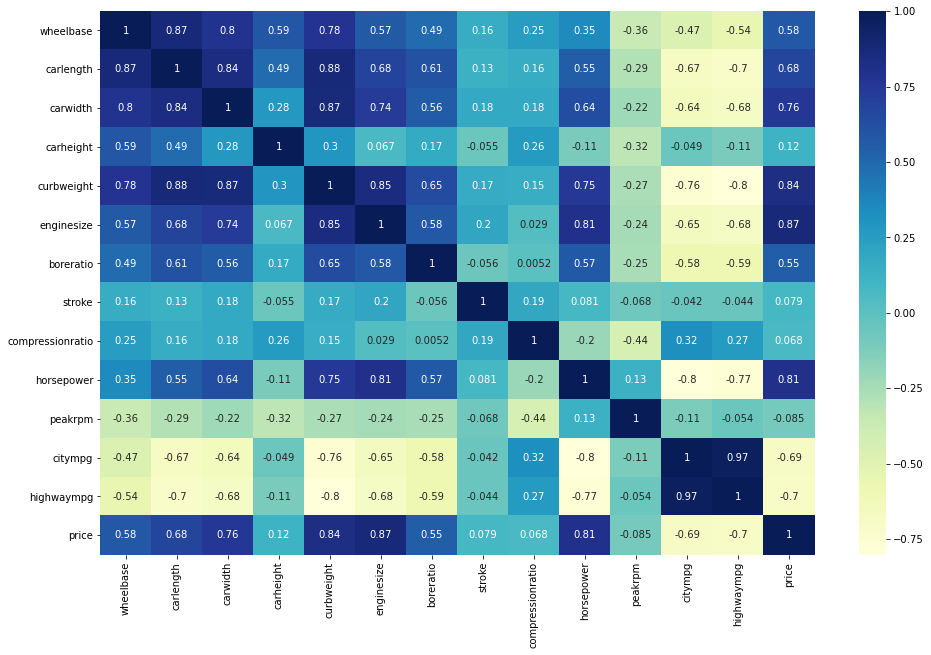

In [14]:
plt.figure(figsize = (16, 10))
sns.heatmap(cars[num_cols].corr(), annot = True, cmap="YlGnBu")
plt.show()

**Observations**

1. We can see a high positive/negative cor-relation between price and predictor features
2. stroke, compressionratio, peakrpm seems they dont't have much relationship which was also visible from the scatter plot. 
3. Citympg & highwaympg have a very high cor-relation, which is intuitive.
4. Also, wheelbase-carlength-carwidth have high co-relation as these design elements effect each other.
5. curbweight-enginesize-boreratio are also positively co-related as they are related to performance.

## Step 3: Data Preparation

#### Outliers

Let's plot a historgram plot and then the quantiles to see outliers. As we know, Outliers affect Linear Regression modell, we will try to clip the outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FDC34B6828>,
      dtype=object)

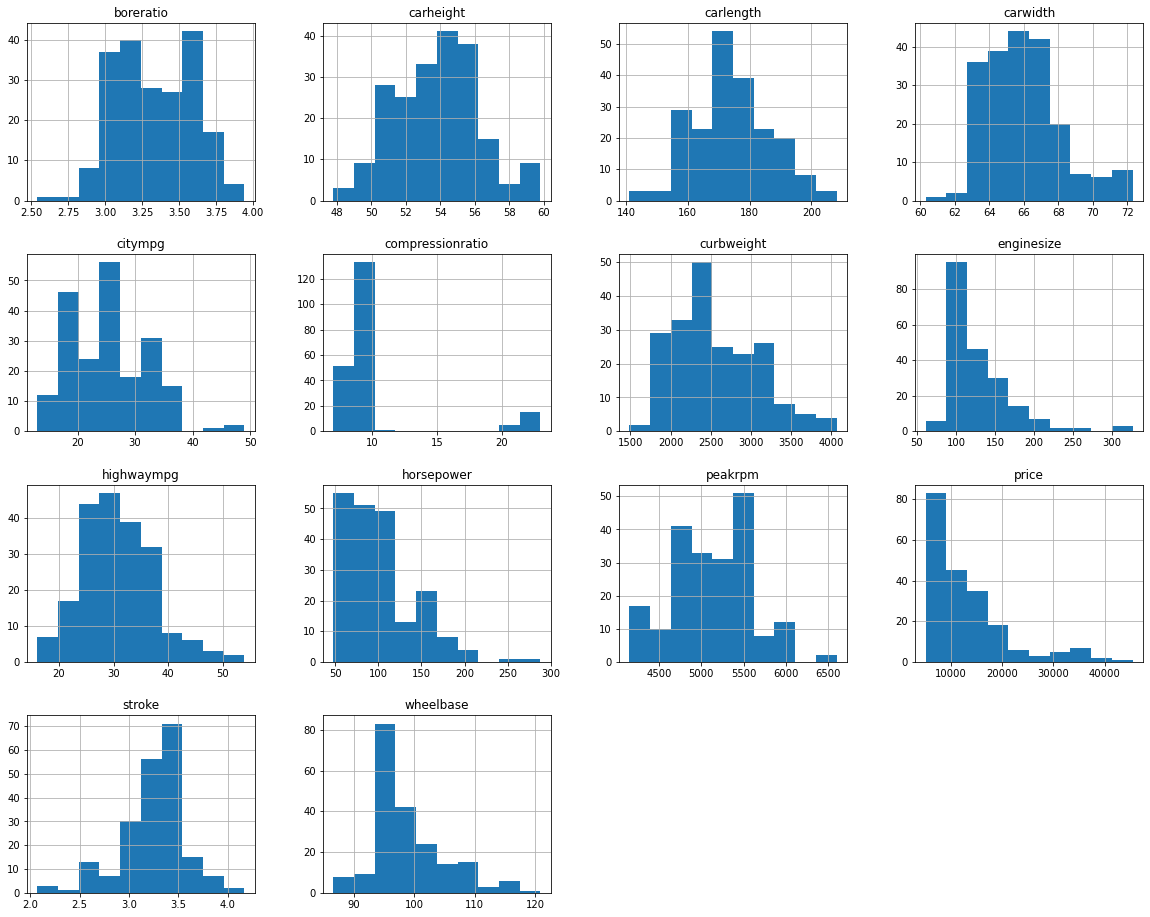

In [15]:
cars[num_cols].hist(figsize=(20,16))

In [16]:
# Checking Quantiles to confirm outliers
print(cars[num_cols].quantile([0.01,0.1,0.3,0.5,0.7,0.90,0.95,0.96,0.97,0.98,0.99,1]))

      wheelbase  carlength  carwidth  carheight  curbweight  enginesize  \
0.01     88.408    144.816    62.536     48.824     1819.72       70.00   
0.10     93.700    157.300    63.800     50.600     1947.00       91.00   
0.30     95.300    168.720    64.400     52.420     2242.80       98.00   
0.50     97.000    173.200    65.500     54.100     2414.00      120.00   
0.70    100.400    177.800    66.500     55.100     2816.60      136.00   
0.90    107.900    188.800    68.640     56.620     3230.00      181.00   
0.95    110.000    196.360    70.460     57.500     3503.00      201.20   
0.96    112.840    198.900    70.852     58.636     3657.80      209.00   
0.97    114.056    198.900    71.400     58.700     3737.00      231.00   
0.98    114.200    199.568    71.676     59.068     3768.40      256.08   
0.99    115.544    202.480    71.700     59.100     3948.00      302.16   
1.00    120.900    208.100    72.300     59.800     4066.00      326.00   

      boreratio  stroke 

In [17]:
# Outliers in price of cars
cars['curbweight'][np.abs(cars['curbweight'] > 3657.80)]= 3657.80 # Quantile value at 0.96
cars['horsepower'][np.abs(cars['horsepower'] > 182.00)]= 180.00 # Quantile value at 0.96
cars['enginesize'][np.abs(cars['enginesize'] > 209.00)]= 209.00 # Quantile valie at 0.96
cars['compressionratio'][np.abs(cars['compressionratio'] > 10.94)]= 10.94 # Quantile value at  0.90
# cars['citympg'][np.abs(cars['citympg'] > 38.00)]= 38.00 # Quantile value at 0.96

**Observation**

1. From the sharp difference between .90 , 0.95,0.96 & 0.99 quantile, we can conclude that the following have outliers :
    - curbweight
    - enginesize
    - compressionratio
    - citympg
    - horsepower
    - price

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FDBAB61A90>,
      dtype=object)

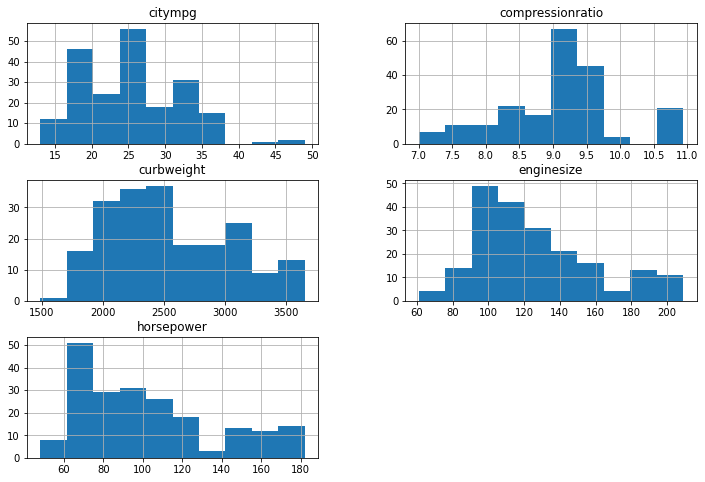

In [18]:
# Distribution after handling outliers
cars[['curbweight','horsepower','enginesize','compressionratio','citympg']].hist(figsize=(12,8))

#### Derived Features

For the correlation we found some highly co-related features which are intuitive. We merge those features and drop the original one.

In [19]:
# Creating new variable wh_ratio
cars['wh_ratio'] = cars.carwidth/cars.carheight

# Creating new variable lw_ratio
cars['lw_ratio'] = cars.carlength/cars.carwidth

# Creating new variable lw_ratio
cars['lh_ratio'] = cars.carlength/cars.carheight

# Creating new variable car_volume
cars['car_volume'] = cars.carlength * cars.carwidth * cars.carheight

# Creating new variable hc_mpgratio
cars['hc_mpgratio'] = cars.highwaympg/cars.citympg

# Creating new variable pw_ratio
cars['pw_ratio'] = cars.horsepower/cars.curbweight

# # Creating new variable pw_ratio
# cars['car_eng_weig_ratio'] = cars.curbweight / cars.enginesize

# droping the orignal variables
cars.drop(['carlength','carwidth','carheight','highwaympg','citympg'],axis=1,inplace=True)

#### Handling Categorical Features

We map the categorical features with only 2 features to 0 and 1.
For **cylindernumber** we don't create dummy variables as the order matters.So we just convert them to numeric form.
For **symbolic** feature, as they are ratings in which orders matter as well, we won't create dummy variables for them.

In [20]:
# Converting categorical variables with two levels to either 1 or 0
def map_cat_features(data) :
    
    data['fueltype'] = data['fueltype'].map({'gas': 1, 'diesel': 0})
    data['aspiration'] = data['aspiration'].map({'std': 1, 'turbo': 0})
    data['doornumber'] = data['doornumber'].map({'two': 1, 'four': 0})
    data['enginelocation'] = data['enginelocation'].map({'front': 1, 'rear': 0})
    data['cylindernumber'] = data['cylindernumber'].map({'two': 2,'three':3,'four':4,'five':5,'six':6,'eight':8, 'twelve': 12})
    
    return data

In [21]:
cars =map_cat_features(cars)
cars.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,curbweight,enginetype,...,horsepower,peakrpm,price,car_company,wh_ratio,lw_ratio,lh_ratio,car_volume,hc_mpgratio,pw_ratio
0,3,1,1,1,convertible,rwd,1,88.6,2548.0,dohc,...,111,5000,13495.0,alfa-romero,1.313525,2.633385,3.459016,528019.904,1.285714,0.043564
1,3,1,1,1,convertible,rwd,1,88.6,2548.0,dohc,...,111,5000,16500.0,alfa-romero,1.313525,2.633385,3.459016,528019.904,1.285714,0.043564
2,1,1,1,1,hatchback,rwd,1,94.5,2823.0,ohcv,...,154,5000,16500.0,alfa-romero,1.250000,2.613740,3.267176,587592.640,1.368421,0.054552
3,2,1,1,0,sedan,fwd,1,99.8,2337.0,ohc,...,102,5500,13950.0,audi,1.219153,2.667674,3.252302,634816.956,1.250000,0.043646
4,2,1,1,0,sedan,4wd,1,99.4,2824.0,ohc,...,115,5500,17450.0,audi,1.222836,2.659639,3.252302,636734.832,1.222222,0.040722


In [22]:
# Creating dummy variables
features = pd.get_dummies(cars)
# Droping 1 dummy variable and Keeping n-1 varaibles for each feature 
features.drop(['carbody_hatchback',
         'drivewheel_4wd',
         'enginetype_l',
         'fuelsystem_1bbl'],axis=1,inplace=True)
features.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'enginelocation',
       'wheelbase', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'price',
       'wh_ratio', 'lw_ratio', 'lh_ratio', 'car_volume', 'hc_mpgratio',
       'pw_ratio', 'carbody_convertible', 'carbody_hardtop', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohc',
       'enginetype_dohcv', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi',
       'car_company_alfa-romero', 'car_company_audi', 'car_company_bmw',
       'car_company_buick', 'car_company_chevrolet', 'car_company_dodge',
       'car_company_honda', 'car_company_isuzu', 'car_company_jaguar',
       'car_company_mazda', 'car_company_mercury', 'car_company_mitsub

## Step 4: Splitting the Data into Training and Testing Sets

In [23]:
df_train, df_test = train_test_split(features, train_size = 0.7, test_size = 0.3, random_state = 42)

In [24]:
df_train.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'enginelocation',
       'wheelbase', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'price',
       'wh_ratio', 'lw_ratio', 'lh_ratio', 'car_volume', 'hc_mpgratio',
       'pw_ratio', 'carbody_convertible', 'carbody_hardtop', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd', 'enginetype_dohc',
       'enginetype_dohcv', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi',
       'car_company_alfa-romero', 'car_company_audi', 'car_company_bmw',
       'car_company_buick', 'car_company_chevrolet', 'car_company_dodge',
       'car_company_honda', 'car_company_isuzu', 'car_company_jaguar',
       'car_company_mazda', 'car_company_mercury', 'car_company_mitsub

#### Rescaling the Features¶

In [25]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['wheelbase','curbweight','enginesize','boreratio','stroke',
            'compressionratio','horsepower','peakrpm',
            'wh_ratio','lw_ratio','lh_ratio','car_volume','pw_ratio','hc_mpgratio','price']

# cars.drop(['carlength','carwidth','carheight','highwaympg','citympg'],axis=1,inplace=True)
# 
# Using MinMaxScaler to scale all the numeric variables in the same scale between 0 and 1.
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,symboling,fueltype,aspiration,doornumber,enginelocation,wheelbase,curbweight,cylindernumber,enginesize,boreratio,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
177,-1,1,1,0,1,0.544828,0.347509,4,0.374101,0.550000,...,0,0,0,0,0,0,0,1,0,0
75,1,1,0,1,1,0.555172,0.593322,4,0.503597,0.885714,...,0,0,0,0,0,0,0,0,0,0
174,-1,0,0,0,1,0.544828,0.359474,4,0.287770,0.521429,...,0,0,0,0,0,0,0,1,0,0
31,2,1,1,1,1,0.000000,0.000000,4,0.158273,0.264286,...,0,0,0,0,0,0,0,0,0,0
12,0,1,1,1,1,0.503448,0.484555,6,0.676259,0.550000,...,0,0,0,0,0,0,0,0,0,0


#### Dividing into X and Y sets for the model building

In [26]:
y_train = df_train.pop('price')
X_train = df_train

## Step 5: Building a Linear Model

We will now use, Linear Regression following the below methods :

1. Automate feature selection via RFE to select 12 features out of 62
2. Use Statmodels to get statiscal information on the features and eliminate features finely
3. Conduct Error Analysis to confirm the model behaviour.
4. Prediction & Evaluation

In [27]:
#Function to fit the linear regression model from the statmodel package
def train_lm(X_train):    
    
    # Adding a constant variable  
    X_train = sm.add_constant(X_train)
    lm = sm.OLS(y_train,X_train).fit() 
    print(lm.summary())
    return lm

# Calculate the VIFs for  model
def get_vif(X_train):
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

# Function for Prediction using linear regression model from the stat model package
def lm_predict(lm,X_train) :
    
    # Adding a constant variable  
    X_train = sm.add_constant(X_train)
    y_train_pred = lm.predict(X_train)
    return y_train_pred
    

#### Feature Selection with RFE

In [28]:
# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 12)             # running RFE and selecting 15 features best describing the price of cars
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('symboling', False, 48),
 ('fueltype', False, 40),
 ('aspiration', False, 25),
 ('doornumber', False, 49),
 ('enginelocation', True, 1),
 ('wheelbase', False, 33),
 ('curbweight', False, 29),
 ('cylindernumber', False, 35),
 ('enginesize', False, 43),
 ('boreratio', False, 6),
 ('stroke', False, 28),
 ('compressionratio', False, 44),
 ('horsepower', True, 1),
 ('peakrpm', False, 22),
 ('wh_ratio', True, 1),
 ('lw_ratio', True, 1),
 ('lh_ratio', True, 1),
 ('car_volume', True, 1),
 ('hc_mpgratio', False, 12),
 ('pw_ratio', True, 1),
 ('carbody_convertible', False, 3),
 ('carbody_hardtop', False, 4),
 ('carbody_sedan', False, 50),
 ('carbody_wagon', False, 23),
 ('drivewheel_fwd', False, 39),
 ('drivewheel_rwd', False, 21),
 ('enginetype_dohc', False, 37),
 ('enginetype_dohcv', False, 9),
 ('enginetype_ohc', False, 38),
 ('enginetype_ohcf', True, 1),
 ('enginetype_ohcv', False, 34),
 ('enginetype_rotor', False, 5),
 ('fuelsystem_2bbl', False, 26),
 ('fuelsystem_4bbl', False, 45),
 ('fu

In [29]:
print("Columns Selected by RFE : {}".format(X_train.columns[rfe.support_]))
print("Columns Rejected by RFE : {}".format(X_train.columns[~rfe.support_]))

Columns Selected by RFE : Index(['enginelocation', 'horsepower', 'wh_ratio', 'lw_ratio', 'lh_ratio',
       'car_volume', 'pw_ratio', 'enginetype_ohcf', 'car_company_bmw',
       'car_company_buick', 'car_company_jaguar', 'car_company_subaru'],
      dtype='object')
Columns Rejected by RFE : Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'wheelbase',
       'curbweight', 'cylindernumber', 'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'peakrpm', 'hc_mpgratio', 'carbody_convertible',
       'carbody_hardtop', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohc', 'enginetype_dohcv',
       'enginetype_ohc', 'enginetype_ohcv', 'enginetype_rotor',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mfi', 'fuelsystem_mpfi', 'fuelsystem_spdi',
       'fuelsystem_spfi', 'car_company_alfa-romero', 'car_company_audi',
       'car_company_chevrolet', 'car_company_dodge', 'car_company_honda',
   

##### Building model using statsmodel, for the detailed statistics

In [30]:
# Creating X_test dataframe with RFE selected variables
col = X_train.columns[rfe.support_] 
X_train_rfe = X_train[col]
lm=train_lm(X_train_rfe)
## Let's check the VIF
get_vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     192.5
Date:                Sat, 30 May 2020   Prob (F-statistic):           3.57e-75
Time:                        16:54:41   Log-Likelihood:                 235.00
No. Observations:                 143   AIC:                            -446.0
Df Residuals:                     131   BIC:                            -410.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1300      0

,Features,VIF
0,enginelocation,2828.03
4,lh_ratio,1193.85
2,wh_ratio,716.02
3,lw_ratio,658.45
7,enginetype_ohcf,162.57
11,car_company_subaru,126.18
1,horsepower,20.47
6,pw_ratio,12.71
5,car_volume,7.05
10,car_company_jaguar,2.03


From the p value & VIF we can observe the following things :
1. The models has an Adjusted R2 as 0.93 , which is very good in capturing the variance in the data.
2. lw_ratio, lh_ratio, wh_ratio have high p-value, i.e. less significance.
3. VIF shows that we have some highly multi-colinear predictors : enginelocation,lw_ratio, lh_ratio, wh_ratio, enginetype_ohcf,car_company_subaru,horsepower ,pw_ratio
4. High VIF makes sense as lw_ratio, lh_ratio, wh_ratio are inter-related with car-dimensions, while pw_ratio is related to horsepower ,pw_ratio as we created these features.

We will finely tune the variables in the following approach :
1. Drop Variables with high p-value one at a time
2. Drop predictors with high VIF.
3. Check for any other possibility

In [31]:
# Drop the variable with highest p-value
X_train_t1 =X_train_rfe.drop('lw_ratio',axis = 1)

lm=train_lm(X_train_t1)
## Let's check the VIF
get_vif(X_train_t1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     213.1
Date:                Sat, 30 May 2020   Prob (F-statistic):           2.56e-76
Time:                        16:54:41   Log-Likelihood:                 234.92
No. Observations:                 143   AIC:                            -447.8
Df Residuals:                     132   BIC:                            -415.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1926      0

,Features,VIF
0,enginelocation,64.13
1,horsepower,19.31
5,pw_ratio,12.11
6,enginetype_ohcf,8.27
10,car_company_subaru,7.64
4,car_volume,7.03
3,lh_ratio,6.94
2,wh_ratio,5.39
9,car_company_jaguar,1.39
8,car_company_buick,1.34


**Observation**

The Adjusted R2 is not affected at all. This means that **lw_ratio** was an insignificant variable.
Now, we see that p-value for all predictor variables is less, indicating they are significant.

Let's continue, feature elimination based on VIF

In [32]:
# Drop the variable with highest VIF
X_train_t2 =X_train_t1.drop('enginelocation',axis = 1)

lm=train_lm(X_train_t2)
## Let's check the VIF
get_vif(X_train_t2)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     213.1
Date:                Sat, 30 May 2020   Prob (F-statistic):           2.56e-76
Time:                        16:54:41   Log-Likelihood:                 234.92
No. Observations:                 143   AIC:                            -447.8
Df Residuals:                     132   BIC:                            -415.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0342      0

,Features,VIF
2,lh_ratio,56.24
1,wh_ratio,30.60
4,pw_ratio,23.77
0,horsepower,18.07
3,car_volume,12.74
5,enginetype_ohcf,4.89
9,car_company_subaru,4.68
8,car_company_jaguar,1.41
7,car_company_buick,1.37
6,car_company_bmw,1.12


**Observation**

The Adjusted R2 is not affected at all. This means that **enginelocation** can be completely explained by other variables.

Let's continue dropping the othervariables based on VIF

In [33]:
# Drop the variable with highest VIF
X_train_t3 =X_train_t2.drop('lh_ratio',axis = 1)

lm=train_lm(X_train_t3)
## Let's check the VIF
get_vif(X_train_t3)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     201.9
Date:                Sat, 30 May 2020   Prob (F-statistic):           5.02e-73
Time:                        16:54:41   Log-Likelihood:                 223.75
No. Observations:                 143   AIC:                            -427.5
Df Residuals:                     133   BIC:                            -397.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0271      0

,Features,VIF
3,pw_ratio,23.03
0,horsepower,16.88
1,wh_ratio,8.84
4,enginetype_ohcf,4.89
8,car_company_subaru,4.68
2,car_volume,4.35
7,car_company_jaguar,1.37
6,car_company_buick,1.33
5,car_company_bmw,1.10


**Observation**

The Adjusted R2 decreased very slightly. This means that **lh_ratio** was safe to remove and did not capture a lot of variance.

Let's continue dropping the other variables based on VIF now.

In [34]:
# Drop the variable with highest VIF
X_train_t4 =X_train_t3.drop('pw_ratio',axis = 1)

lm1=train_lm(X_train_t4)
## Let's check the VIF
get_vif(X_train_t4)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     201.4
Date:                Sat, 30 May 2020   Prob (F-statistic):           8.95e-71
Time:                        16:54:41   Log-Likelihood:                 215.25
No. Observations:                 143   AIC:                            -412.5
Df Residuals:                     134   BIC:                            -385.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1502      0

,Features,VIF
0,horsepower,7.29
3,enginetype_ohcf,4.77
1,wh_ratio,4.72
7,car_company_subaru,4.65
2,car_volume,4.32
6,car_company_jaguar,1.13
5,car_company_buick,1.12
4,car_company_bmw,1.10


**Observation**

The Adjusted R2 decreased very slightly. This means that **pw_ratio** was an insignificant variable.
Though we also see the sharp drop in the VIF values.

Let's continue dropping the other variables based on VIF now.
This is our candidate **Model 1**

In [35]:
# Drop the variable with VIF
X_train_t5 =X_train_t4.drop('horsepower',axis = 1)

lm2=train_lm(X_train_t5)
## Let's check the VIF
get_vif(X_train_t5)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     143.5
Date:                Sat, 30 May 2020   Prob (F-statistic):           2.58e-59
Time:                        16:54:42   Log-Likelihood:                 184.26
No. Observations:                 143   AIC:                            -352.5
Df Residuals:                     135   BIC:                            -328.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2038      0

,Features,VIF
2,enginetype_ohcf,4.10
6,car_company_subaru,4.03
1,car_volume,3.06
0,wh_ratio,3.02
4,car_company_buick,1.11
5,car_company_jaguar,1.08
3,car_company_bmw,1.07


**Observation**

We get a major drop, in Adjusted R2 value. Also **horsepower** is a key feature for business interpretabilty. We will keep this model as a candidate for model selection.

Let's drop another variable **wh_ratio** and see what happens. Intuitively , the **car_volume** feature is capturing in some essence the width & height components and hence the ratio.

This is our candidate **Model 2**

In [36]:
# Drop the variable with highest p-value
X_train_t6 =X_train_t4.drop('wh_ratio',axis = 1)

lm3=train_lm(X_train_t6)
## Let's check the VIF
get_vif(X_train_t6)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     175.7
Date:                Sat, 30 May 2020   Prob (F-statistic):           1.38e-64
Time:                        16:54:42   Log-Likelihood:                 197.17
No. Observations:                 143   AIC:                            -378.3
Df Residuals:                     135   BIC:                            -354.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0501      0

,Features,VIF
2,enginetype_ohcf,4.70
0,horsepower,4.66
6,car_company_subaru,4.53
1,car_volume,4.16
5,car_company_jaguar,1.13
4,car_company_buick,1.11
3,car_company_bmw,1.08


**Observation**

Our intuition was correct, dropping the **wh_ratio** , leads to reduction in VIF for the other predictors and we can retain the **horse_power** feature.

Also, the adusted R2 is better than when we dropped horsepower. This is our candidate **Model 3**

Hence, we selected the last 3 models for evaluation & model selection.

## Step 6: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [37]:
y_train_price_t4 = lm_predict(lm1,X_train_t4) # Adj. R-squared 0.919 
y_train_price_t5 = lm_predict(lm2,X_train_t5) # Adj. R-squared 0.875 | horse_power dropped
y_train_price_t6 = lm_predict(lm3,X_train_t6) # Adj. R-squared 0.896 | wh_ratio dropped

In [38]:
def plot_error(train,pred,idx,title="") :
    # Plot the histogram of the error terms
    plt.subplot(1,3,idx)
    ax = sns.distplot((train - pred), bins = 15)
    ax.set_title(title)
    plt.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
    plt.xlabel('Errors', fontsize = 18)   

def plot_prediction(index,label,pred,idx,title="") :
    # Plot the histogram of the error terms
    ax = plt.subplot(3,1,idx)
    plt.plot(index,label,color="blue")
    plt.plot(index,pred,color="red")
    ax.set_title(title)
    plt.suptitle('Actual v/s Predicted', fontsize = 20)                  # Plot heading 
#     plt.xlabel('Errors', fontsize = 18) 

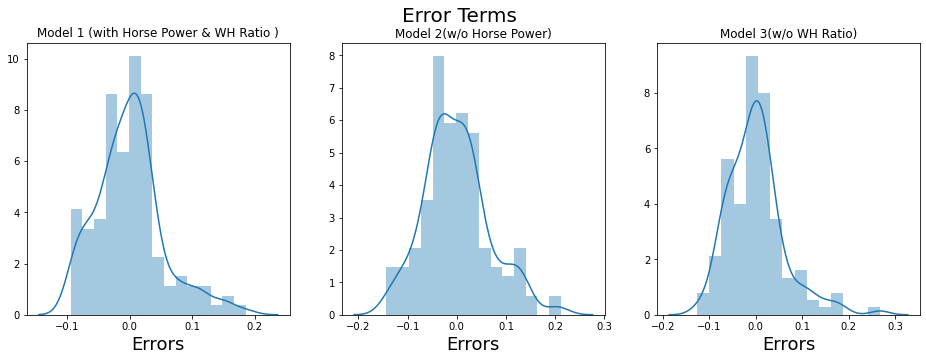

In [39]:
# fig = plt.figure()
plt.figure(figsize=(16, 5))
plot_error(y_train,y_train_price_t4,1,title="Model 1 (with Horse Power & WH Ratio )")
plot_error(y_train,y_train_price_t5,2,title="Model 2(w/o Horse Power)")
plot_error(y_train,y_train_price_t6,3,title="Model 3(w/o WH Ratio)")

**Observations**
1. Error Distribution of all the 3 models closely follow Normal Distribution with nearby 0 mean.
2. Model 1 & 3 have similar characteristics, hihg peak & less deviation.
3. Model 2 on the other hand has distuinguishly a low peak & more deviation

#### Plotting Trend

We now plot Actual v/s Predicted for the all the models to see how the model is able to generalize the predictions

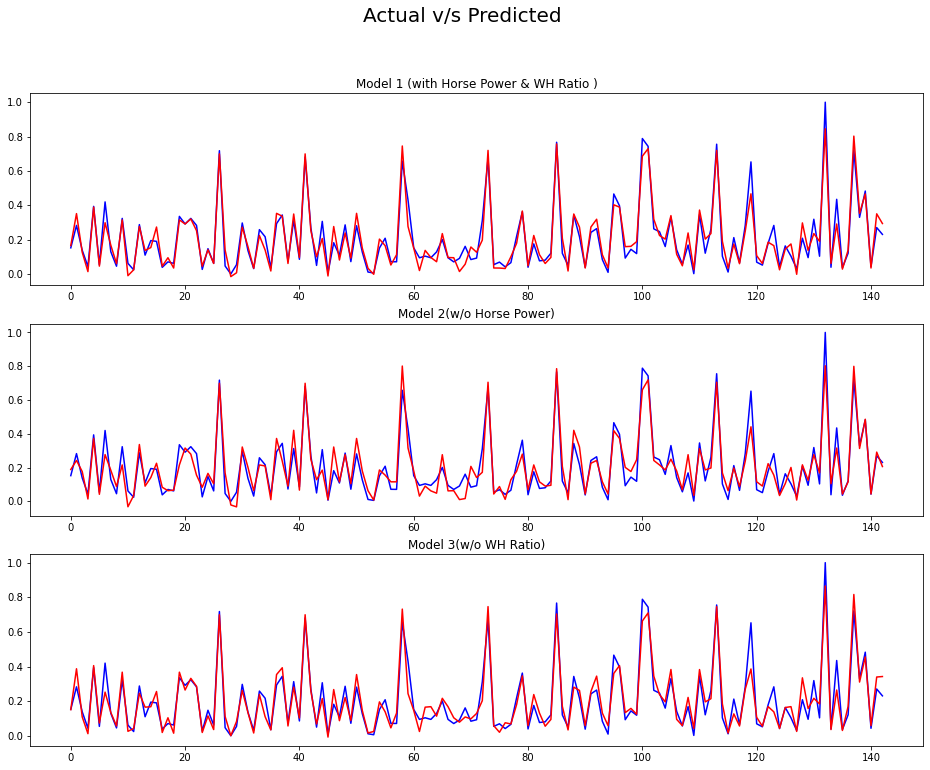

In [40]:

plt.figure(figsize=(16, 12))
index = [i for i in range(y_train.shape[0])]
plot_prediction(index,y_train,y_train_price_t4,1,title="Model 1 (with Horse Power & WH Ratio )")
plot_prediction(index,y_train,y_train_price_t5,2,title="Model 2(w/o Horse Power)")
plot_prediction(index,y_train,y_train_price_t6,3,title="Model 3(w/o WH Ratio)")

**Observations**

1. We can see that the Model 2 (without horse power) fits poorly on the test data, failing to follow the trend.
2. While Model 1 & 3 perform compartively better.

## Step 7: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using our 3 candidate models

In [41]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [42]:
y_test = df_test.pop('price')
X_test = df_test

In [43]:
# Creating Test Set for all the 3 different models
X_test_t4 = X_test[X_train_t4.columns]
X_test_t5 = X_test[X_train_t5.columns]
X_test_t6 = X_test[X_train_t6.columns]

# predictions from all the 3 different models
y_test_price_t4 = lm_predict(lm1,X_test_t4) # Adj. R-squared 0.919 
y_test_price_t5 = lm_predict(lm2,X_test_t5) # Adj. R-squared 0.875 | horse_power dropped
y_test_price_t6 = lm_predict(lm3,X_test_t6) # Adj. R-squared 0.896 | wh_ratio dropped

## Step 8: Model Evaluation & Selection

Let's now plot the graph for Actual versus Predicted values for the test test

In [44]:
def plot_pred(test,pred,idx,title="") :
#     fig = plt.figure()
    ax = plt.subplot(1,3,idx)
    plt.scatter(test, pred)
    ax.set_title(title)
    plt.xlabel('y_test', fontsize = 18) # Y-label                     
    plt.ylabel('y_pred', fontsize = 16) # X-label

def eval_metrics(test,pred,model_details) :
    print("**************************************")
    print("Model Used  : {}".format(model_details))
    rmse = sqrt(mean_squared_error(test, pred))
    print('Model RMSE:',rmse)

    r2=r2_score(test, pred)
    print('Model r2_score:',r2)

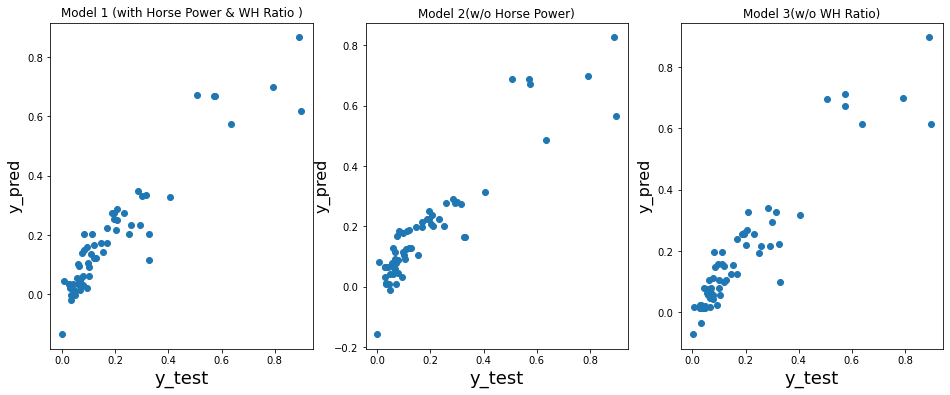

In [45]:
plt.figure(figsize=(16, 6))
plot_pred(y_test,y_test_price_t4,1,title="Model 1 (with Horse Power & WH Ratio )")
plot_pred(y_test,y_test_price_t5,2,title="Model 2(w/o Horse Power)")
plot_pred(y_test,y_test_price_t6,3,title="Model 3(w/o WH Ratio)")

In [46]:
# Checking the Performance Metrices on the Test Set
eval_metrics(y_test,y_test_price_t4,model_details="Model 1 (with Horse Power & WH Ratio )")
eval_metrics(y_test,y_test_price_t5,model_details="Model 2(w/o Horse Power)")
eval_metrics(y_test,y_test_price_t6,model_details="Model 3(w/o WH Ratio)")

**************************************
Model Used  : Model 1 (with Horse Power & WH Ratio )
Model RMSE: 0.07306472012845765
Model r2_score: 0.8749734710799664
**************************************
Model Used  : Model 2(w/o Horse Power)
Model RMSE: 0.07904079389161274
Model r2_score: 0.8536848451244807
**************************************
Model Used  : Model 3(w/o WH Ratio)
Model RMSE: 0.07412758512728741
Model r2_score: 0.8713095177210284


**Inference**

Based on the above scores an score from the training data, it is wiser to chose **Model 3** in which we have the VIF for all predictor variables less than 5 and lesser variables.

Model 2 performs poorly as well as has low interpretability. Model 1 though has a better score in training data, due to it's high VIF , we can safely conclude that the model was overfitting. 
Hence Model 2 is the selected model.

Lets have look at **Model 3** params and VIF as it' our final model

In [47]:
# Check the Co-efficients & VIF of the predictor variables

coeff = pd.DataFrame(lm3.params).reset_index()
vifs = get_vif(X_train_t6)

details = pd.merge(coeff,vifs,how="inner",
                  left_on="index",right_on="Features")

details = details.rename(columns={0:"coeff"})
details = details[["Features","coeff","VIF"]]
details

,Features,coeff,VIF
0,horsepower,0.336107,4.66
1,car_volume,0.214138,4.16
2,enginetype_ohcf,0.359097,4.70
3,car_company_bmw,0.183860,1.08
4,car_company_buick,0.385872,1.11
5,car_company_jaguar,0.314609,1.13
6,car_company_subaru,-0.392334,4.53


**Key Points | Interpretation**

1. We can say, that the price of the car increases by a co-efficient of 0.336107 for a unit increase in horsepower given all other independent variables are held constant.
2. From EDA we saw that price of a car varies highly for differnt engine_types, which is reflected by a positive co-efficient for engine_type_ohcf
3. The Volume of a car which can be attributed to it's dimensions, also positively affects the pricing of a car.
4. We have 4 Car Brands as well for predictors. These can be attributed to how the competitor Brand is valued by the US consumer & market. Based on data exploration, the below can be concluded from brand perception.
    - BMW : Mid-End to High-End cars brand
    - Buick : High-End cars brand with options
    - Jaguar : Exclusive/Prime Car brand, with only High-End Cars
    - Subaru : A Low-End car brand.
5. This also, suggests that we could serve another feature for low/mid/high/luxury brands and group the companies among them.
6. Current Models Metrics :
    - **Adjusted R-squared** : 0.896
    - **r2_score** : 0.871
    - **Prob(F-statistic)** : 2.58e-59
    - **AIC** : -378.3
    - **BIC** : -354.6
    - **RMSE** : 0.074
7. We could have further improved the model by :
    - More features like : area, wheelbase_height_ratio
    - By more stictly handling outliers in citympg, etc.
    - Building a non-linear model


**Suggestions** 

Geely Automotives should consider the below listed points, while entering the US market based on consumer behavior. They can use our model to accordingly price their cars.
    - symboling: neutral (0,1)
    - carbody: Sedan
    - fueltype: gas
    - aspiration: standard
    - doornumbers: four
    - drivewheel: forward
    - engine location: front
    - engine type: ohc
    - cylinderNumber: four
    - fuelSystem: mpfi
The above preferences of teh customers should be kept in mind while designing the car and have a great success.
